In [1]:
import numpy as np 
import os
import skimage.io as io
from skimage import img_as_ubyte
import skimage.transform as trans
import numpy as np
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import glob
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework.config import set_memory_growth


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
    try:
        tf.config.experimental.set_virtual_device_configuration(gpus[0],
       [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=3096)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:

def unet(pretrained_weights = None,input_size = (512,512,3)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
    UpSampling2D(size=(2, 2))(drop5))
    merge6 = concatenate([drop4, up6],axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)
    up7 = Conv2D(256, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
    UpSampling2D(size=(2, 2))(conv6))
    merge7 = concatenate([conv3, up7],axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)
    up8 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
    UpSampling2D(size=(2, 2))(conv7))
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)
    up9 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
    UpSampling2D(size=(2, 2))(conv8))
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)
    model = Model(inputs=inputs, outputs=conv10)

    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

    if(pretrained_weights):
    	model.load_weights(pretrained_weights)

    return model


In [4]:
import numpy as np
TRAIN_PATH = "./dataset/train/images"
MASK_PATH = "./dataset/train/masks/"

def create_train_data():
    imgs = glob.glob(TRAIN_PATH+"/*.png")
    masks = glob.glob(MASK_PATH+"/*.png")
    img_datas = np.ndarray((len(imgs), 512, 512, 3), dtype=np.uint8)
    img_masks = np.ndarray((len(masks), 512, 512, 1), dtype=np.uint8)
    for x in range(len(imgs)):
        imgpath = imgs[x]
        pic_name = imgpath.split('\\')[-1]
        
        maskpath = MASK_PATH + pic_name
        img = load_img(imgpath, grayscale=False, target_size=[512,512])
        mask = load_img(maskpath, grayscale=True, target_size=[512, 512])
        img = img_to_array(img)
        mask = img_to_array(mask)
        img_datas[x] = img
        img_masks[x] = mask
    return img_datas, img_masks


In [5]:
TEST_PATH = "./dataset/test/images"


def create_test_data():
    imgs = glob.glob(TEST_PATH + "/*.png")
    img_datas = np.ndarray((len(imgs), self.out_rows, self.out_cols, 3), dtype=np.uint8)
    for x in range(len(imgs)):
        imgpath = imgs[x]
        img = load_img(imgpath, grayscale=False, target_size=[512, 512])
        img = img_to_array(img)
        img_datas[x] = img
    return img_datas

C:\Users\andri\miniconda3\envs\tf\lib\site-packages\keras\utils\image_utils.py:409: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn(


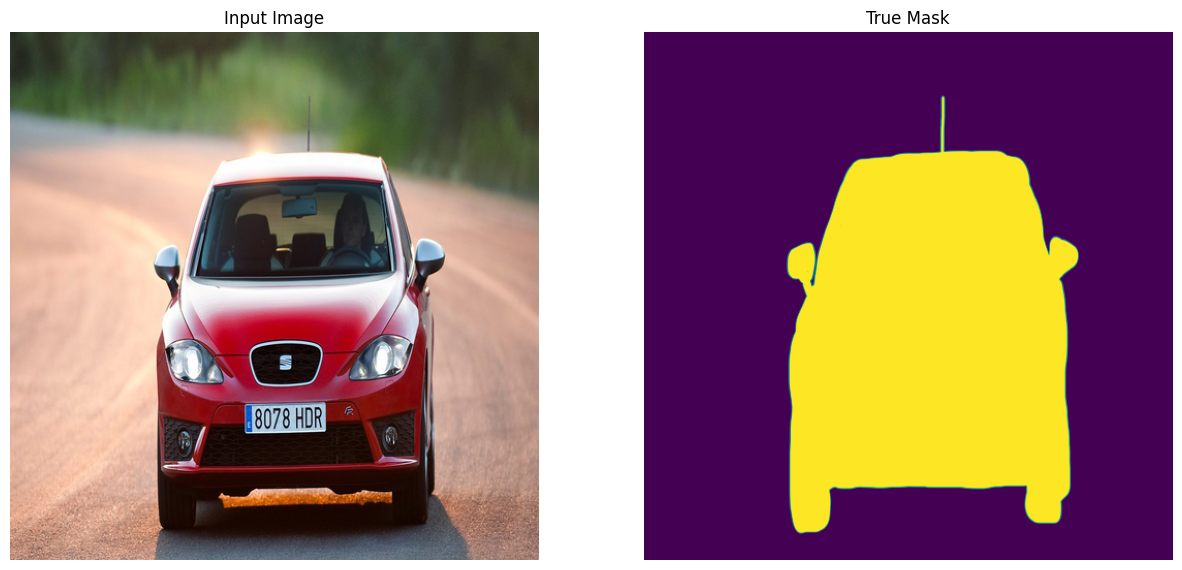

In [6]:
(train_data, train_mask) = create_train_data()
sample_image = train_data[0]
sample_mask = train_mask[0]

def display(display_list):
  plt.figure(figsize=(15, 15))
  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

display([sample_image, sample_mask])

def create_mask(pred_mask):
  return pred_mask[0]

def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])


In [7]:
SAVE_PATH = "./dataset/test/maks/"
def save_images(pred_array):
    for i in range(pred_array.shape[0]):
        img = pred_array[i]
        img = array_to_img(img)
        img.save(SAVE_PATH + "{0}.png".format(i))

1/1 [==============================] - 16s 16s/step


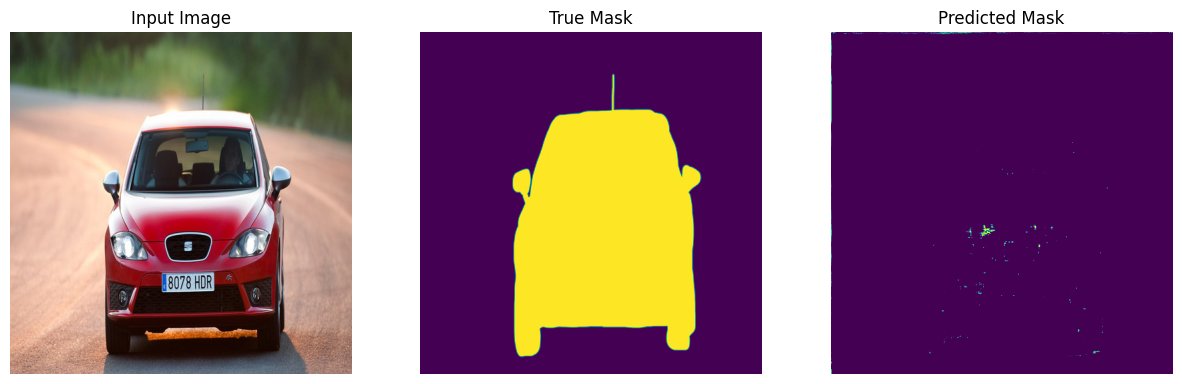

In [8]:
model = unet()
show_predictions()

In [9]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

Starting to fit UNET model..
Epoch 1/50
70/70 [==============================] - ETA: 0s - loss: 149.8528 - accuracy: 0.0068
Epoch 1: loss improved from inf to 149.85278, saving model to unet_car.hdf5
1/1 [==============================] - 0s 27ms/step


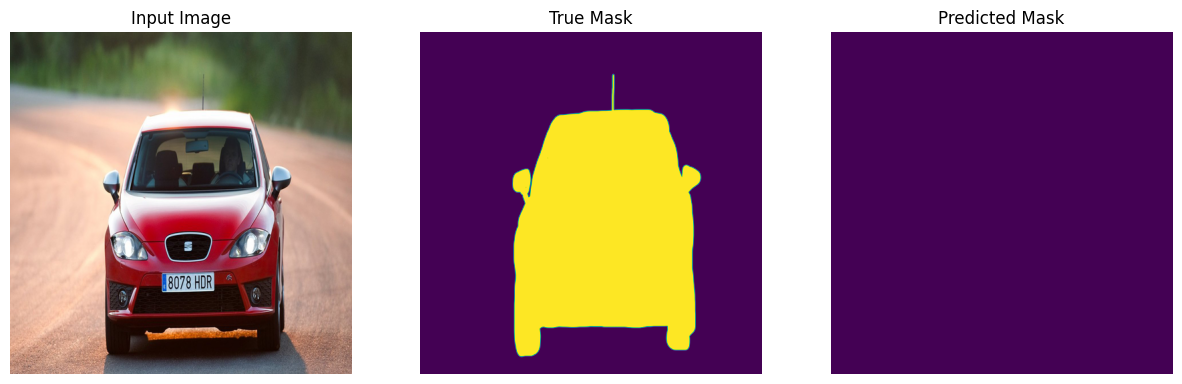


Sample Prediction after epoch 1

70/70 [==============================] - 66s 789ms/step - loss: 149.8528 - accuracy: 0.0068
Epoch 2/50
70/70 [==============================] - ETA: 0s - loss: -8.9722 - accuracy: 2.7400e-04
Epoch 2: loss improved from 149.85278 to -8.97222, saving model to unet_car.hdf5
1/1 [==============================] - 0s 27ms/step


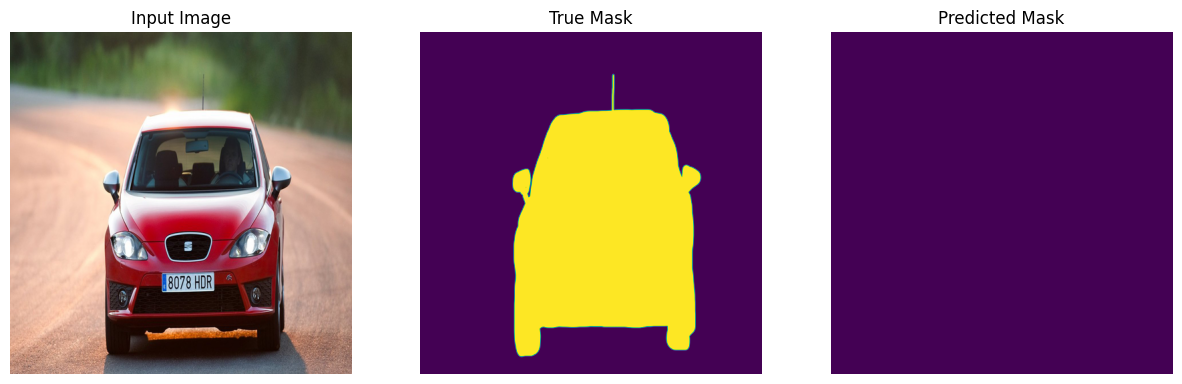


Sample Prediction after epoch 2

70/70 [==============================] - 59s 843ms/step - loss: -8.9722 - accuracy: 2.7400e-04
Epoch 3/50
70/70 [==============================] - ETA: 0s - loss: -15.3677 - accuracy: 2.7400e-04
Epoch 3: loss improved from -8.97222 to -15.36774, saving model to unet_car.hdf5
1/1 [==============================] - 0s 28ms/step


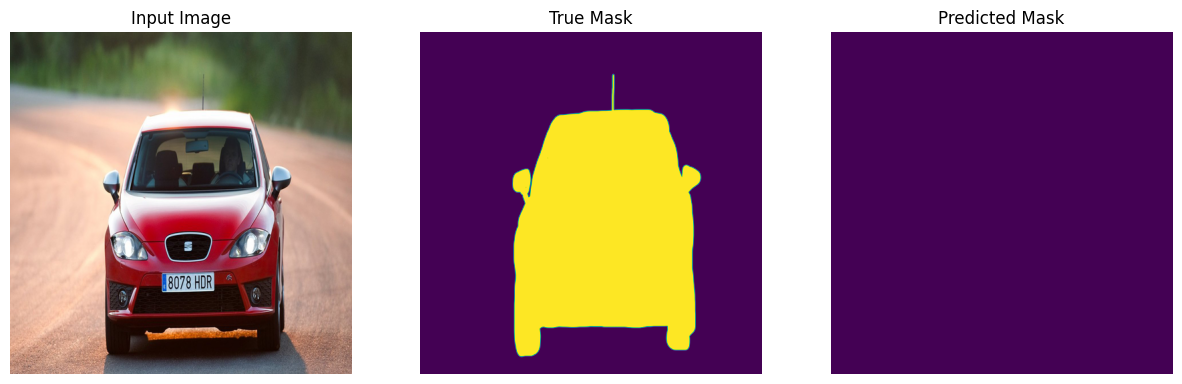


Sample Prediction after epoch 3

70/70 [==============================] - 56s 796ms/step - loss: -15.3677 - accuracy: 2.7400e-04
Epoch 4/50
70/70 [==============================] - ETA: 0s - loss: -21.7584 - accuracy: 2.7400e-04
Epoch 4: loss improved from -15.36774 to -21.75835, saving model to unet_car.hdf5
1/1 [==============================] - 0s 28ms/step


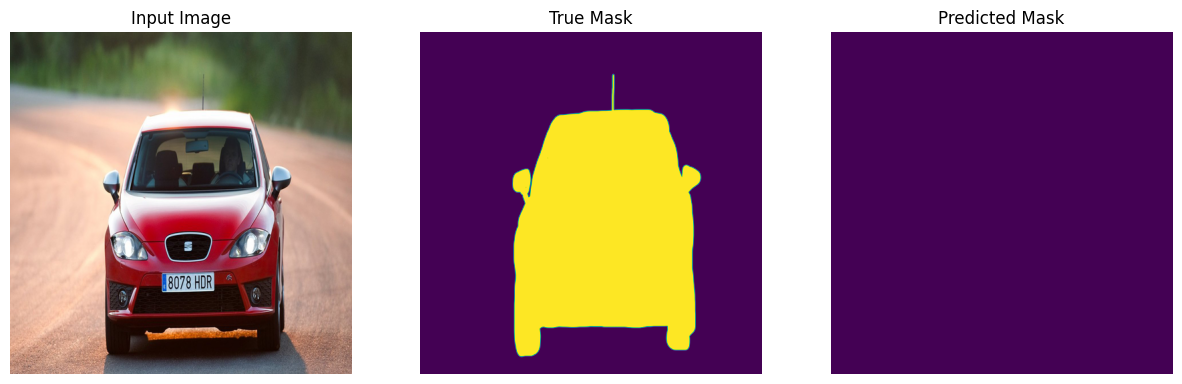


Sample Prediction after epoch 4

70/70 [==============================] - 57s 816ms/step - loss: -21.7584 - accuracy: 2.7400e-04
Epoch 5/50
70/70 [==============================] - ETA: 0s - loss: -28.1345 - accuracy: 2.7400e-04
Epoch 5: loss improved from -21.75835 to -28.13451, saving model to unet_car.hdf5
1/1 [==============================] - 0s 27ms/step


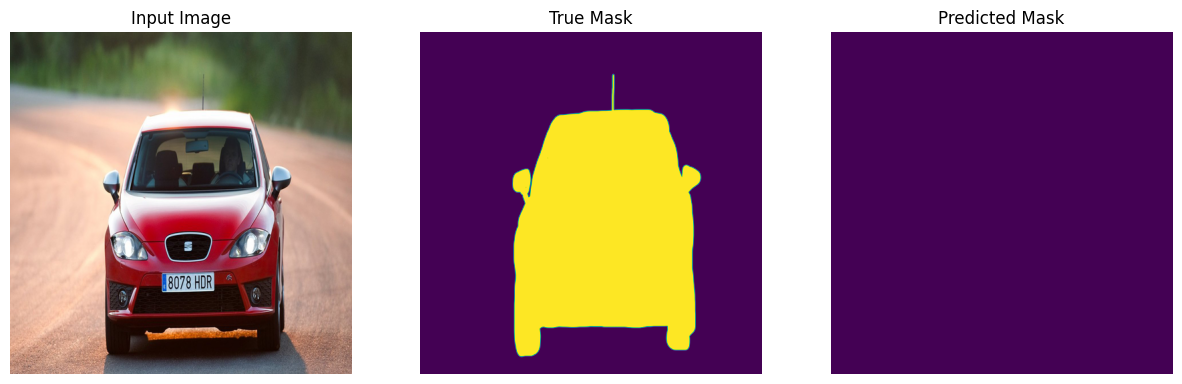


Sample Prediction after epoch 5

70/70 [==============================] - 59s 851ms/step - loss: -28.1345 - accuracy: 2.7400e-04
Epoch 6/50
70/70 [==============================] - ETA: 0s - loss: -34.5045 - accuracy: 2.7400e-04
Epoch 6: loss improved from -28.13451 to -34.50455, saving model to unet_car.hdf5
1/1 [==============================] - 0s 28ms/step


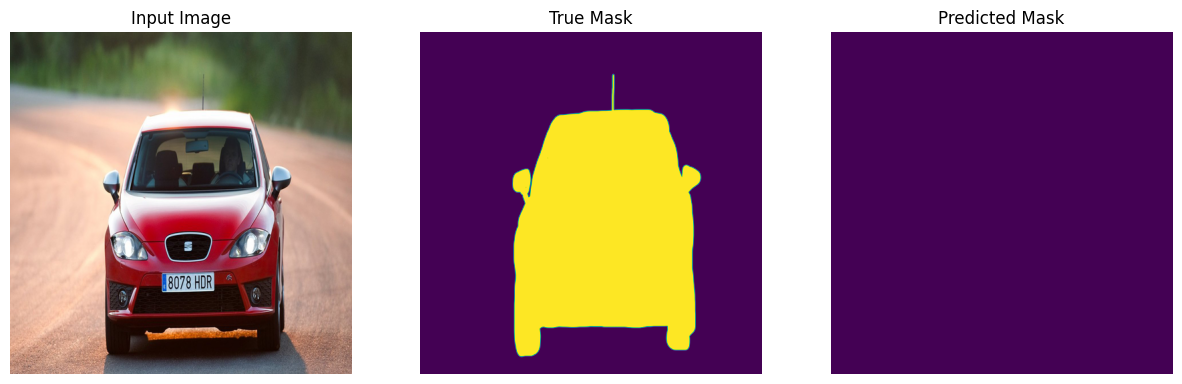


Sample Prediction after epoch 6

70/70 [==============================] - 57s 813ms/step - loss: -34.5045 - accuracy: 2.7400e-04
Epoch 7/50
70/70 [==============================] - ETA: 0s - loss: -40.8979 - accuracy: 2.7400e-04
Epoch 7: loss improved from -34.50455 to -40.89794, saving model to unet_car.hdf5
1/1 [==============================] - 0s 28ms/step


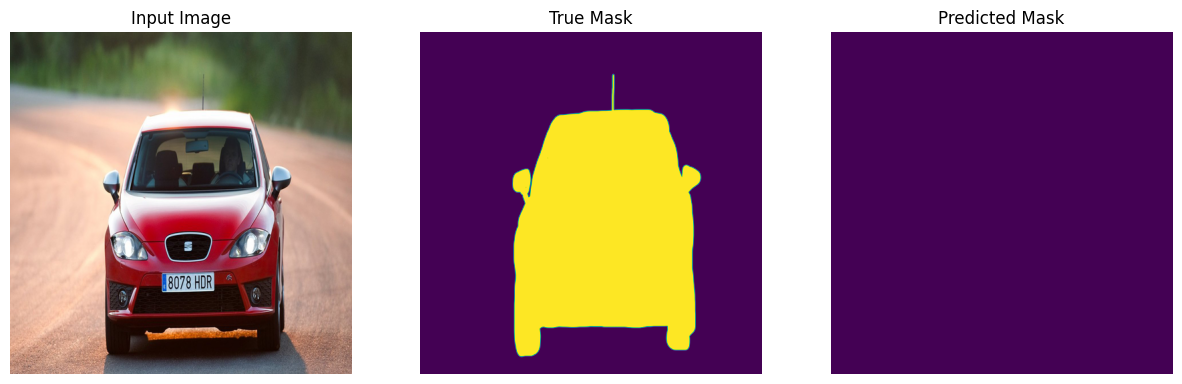


Sample Prediction after epoch 7

70/70 [==============================] - 55s 794ms/step - loss: -40.8979 - accuracy: 2.7400e-04
Epoch 8/50
70/70 [==============================] - ETA: 0s - loss: -47.2726 - accuracy: 2.7400e-04
Epoch 8: loss improved from -40.89794 to -47.27264, saving model to unet_car.hdf5
1/1 [==============================] - 0s 26ms/step


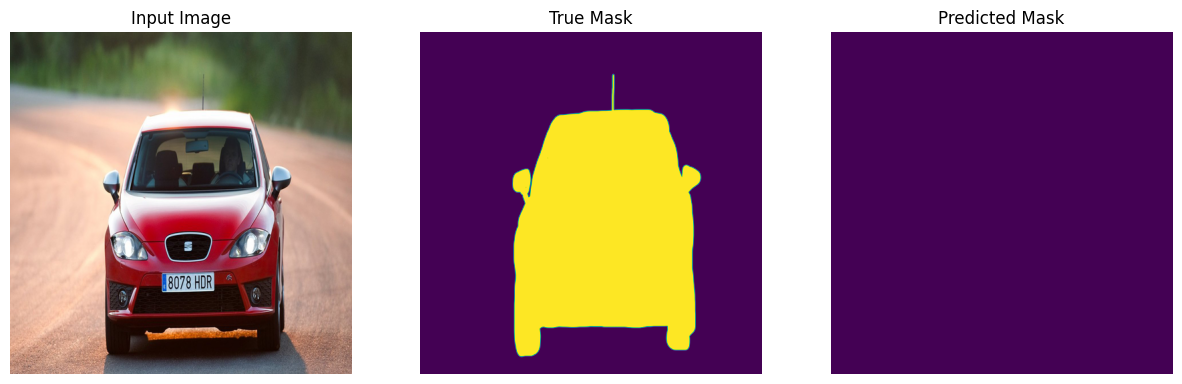


Sample Prediction after epoch 8

70/70 [==============================] - 59s 853ms/step - loss: -47.2726 - accuracy: 2.7400e-04
Epoch 9/50
70/70 [==============================] - ETA: 0s - loss: -53.6210 - accuracy: 2.7400e-04
Epoch 9: loss improved from -47.27264 to -53.62104, saving model to unet_car.hdf5
1/1 [==============================] - 0s 29ms/step


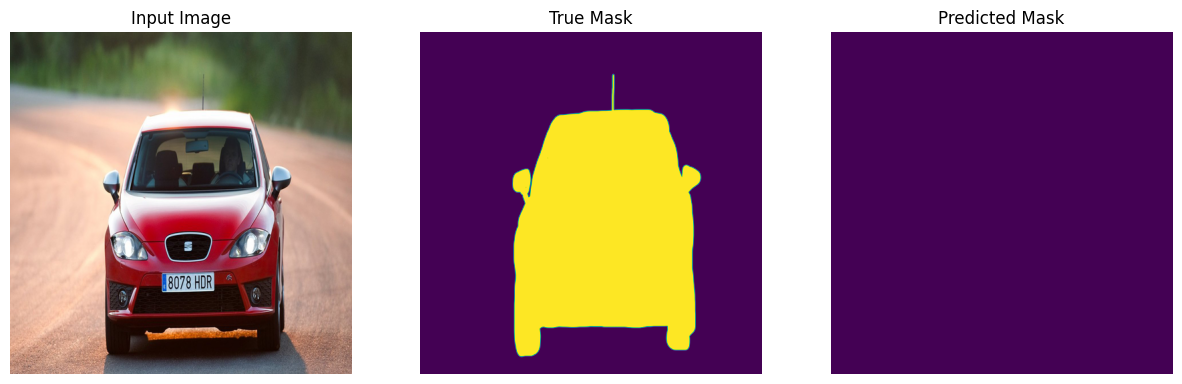


Sample Prediction after epoch 9

70/70 [==============================] - 55s 785ms/step - loss: -53.6210 - accuracy: 2.7400e-04
Epoch 10/50
70/70 [==============================] - ETA: 0s - loss: -60.0111 - accuracy: 2.7400e-04
Epoch 10: loss improved from -53.62104 to -60.01110, saving model to unet_car.hdf5
1/1 [==============================] - 0s 28ms/step


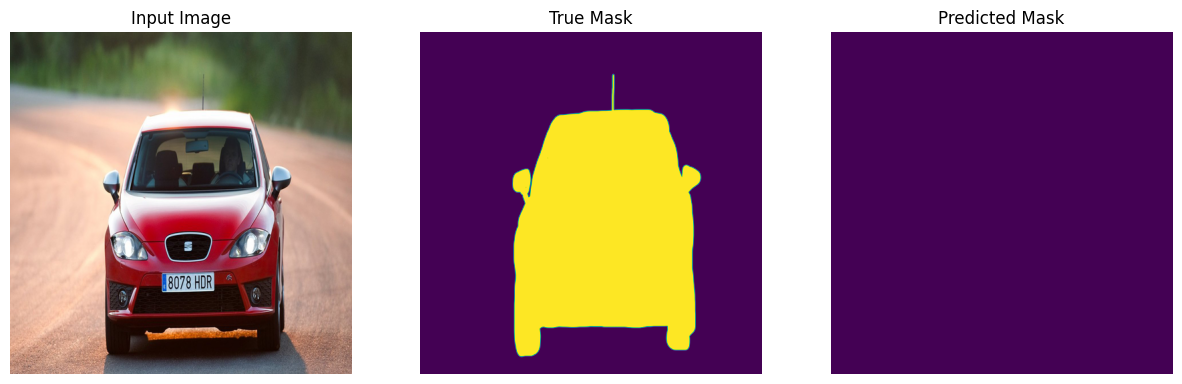


Sample Prediction after epoch 10

70/70 [==============================] - 57s 821ms/step - loss: -60.0111 - accuracy: 2.7400e-04
Epoch 11/50
70/70 [==============================] - ETA: 0s - loss: -66.3714 - accuracy: 2.7400e-04
Epoch 11: loss improved from -60.01110 to -66.37144, saving model to unet_car.hdf5
1/1 [==============================] - 0s 28ms/step


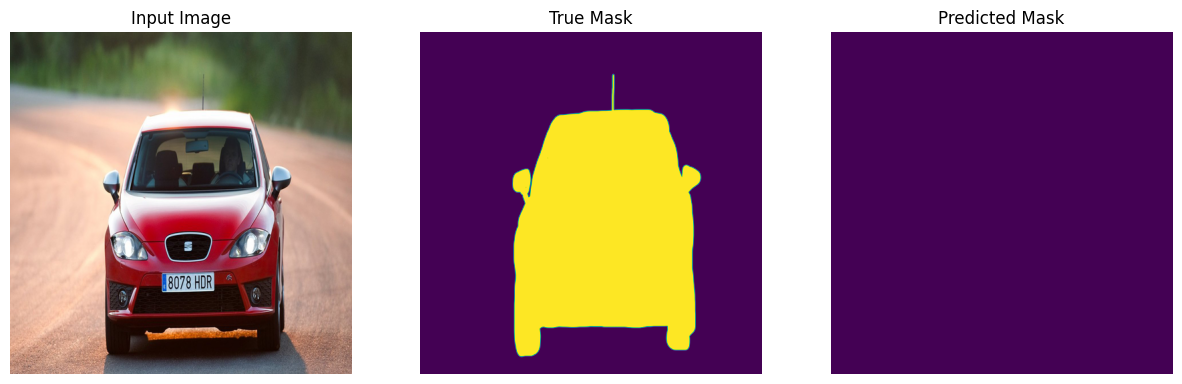


Sample Prediction after epoch 11

70/70 [==============================] - 60s 854ms/step - loss: -66.3714 - accuracy: 2.7400e-04
Epoch 12/50
70/70 [==============================] - ETA: 0s - loss: -72.7394 - accuracy: 2.7400e-04
Epoch 12: loss improved from -66.37144 to -72.73938, saving model to unet_car.hdf5
1/1 [==============================] - 0s 28ms/step


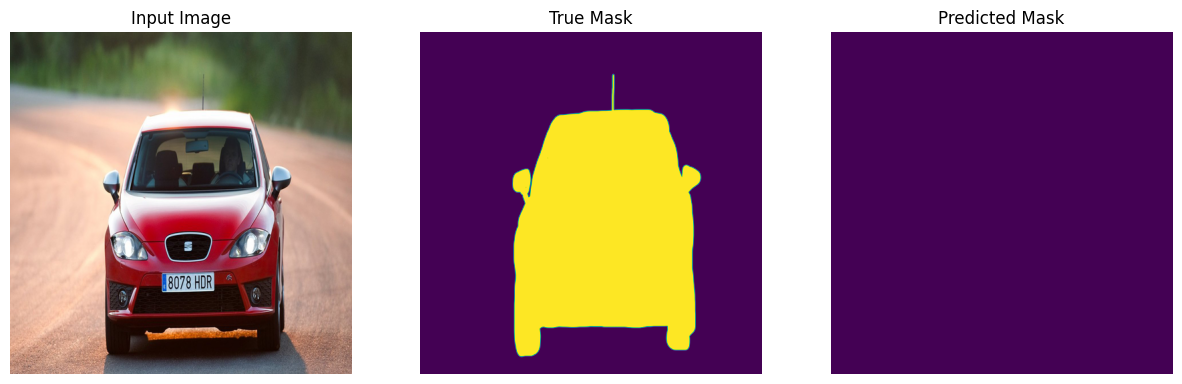


Sample Prediction after epoch 12

70/70 [==============================] - 62s 885ms/step - loss: -72.7394 - accuracy: 2.7400e-04
Epoch 13/50
70/70 [==============================] - ETA: 0s - loss: -79.1150 - accuracy: 2.7400e-04
Epoch 13: loss improved from -72.73938 to -79.11500, saving model to unet_car.hdf5
1/1 [==============================] - 0s 27ms/step


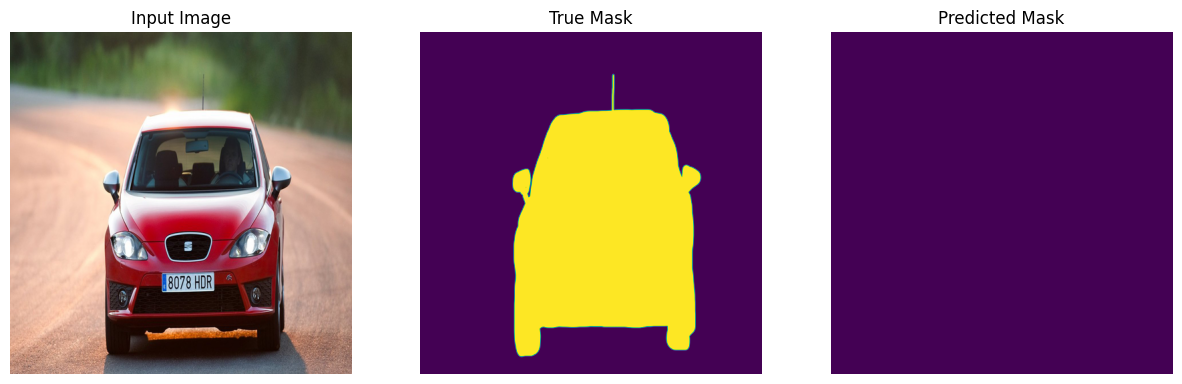


Sample Prediction after epoch 13

70/70 [==============================] - 59s 844ms/step - loss: -79.1150 - accuracy: 2.7400e-04
Epoch 14/50
70/70 [==============================] - ETA: 0s - loss: -85.4833 - accuracy: 2.7400e-04
Epoch 14: loss improved from -79.11500 to -85.48327, saving model to unet_car.hdf5
1/1 [==============================] - 0s 27ms/step


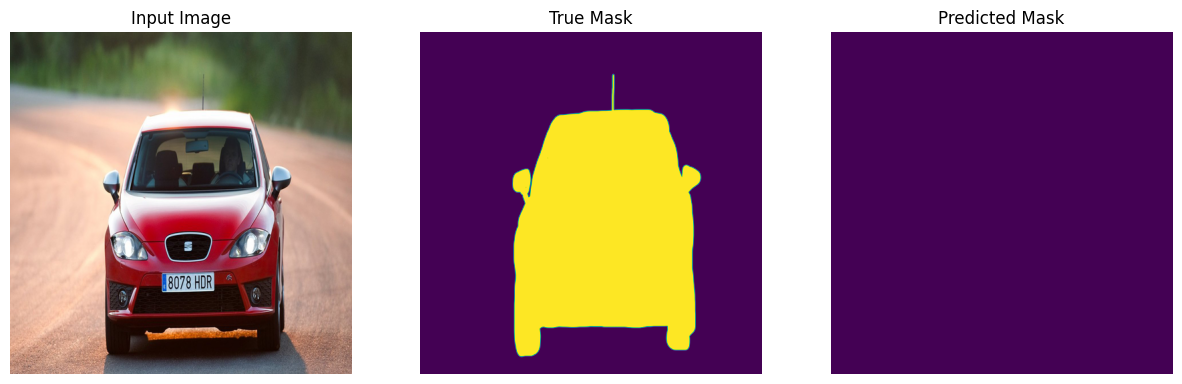


Sample Prediction after epoch 14

70/70 [==============================] - 59s 844ms/step - loss: -85.4833 - accuracy: 2.7400e-04
Epoch 15/50
14/70 [=====>........................] - ETA: 44s - loss: -90.4192 - accuracy: 2.7929e-04

In [ ]:
model_checkpoint = ModelCheckpoint('unet_car.hdf5', monitor='loss',verbose=1, save_best_only=True)
print("Starting to fit UNET model..")
model.fit(train_data, train_mask, batch_size=1, epochs=50, verbose=1,  callbacks=[model_checkpoint, DisplayCallback()])

In [29]:
testGene = testGenerator("dataset/test/images")
print(next(testGene).shape)
results = model.predict(testGene)
saveResult("dataset/test/masks",results)

(1, 256, 256, 3)
     11/Unknown - 1s 77ms/step

InvalidArgumentError: Graph execution error:

Detected at node 'model_2/conv2d_48/Relu' defined at (most recent call last):
    File "C:\Users\andri\miniconda3\envs\tf\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\andri\miniconda3\envs\tf\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\andri\miniconda3\envs\tf\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\andri\miniconda3\envs\tf\lib\site-packages\traitlets\config\application.py", line 1043, in launch_instance
      app.start()
    File "C:\Users\andri\miniconda3\envs\tf\lib\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "C:\Users\andri\miniconda3\envs\tf\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\andri\miniconda3\envs\tf\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "C:\Users\andri\miniconda3\envs\tf\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "C:\Users\andri\miniconda3\envs\tf\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\andri\miniconda3\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "C:\Users\andri\miniconda3\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "C:\Users\andri\miniconda3\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "C:\Users\andri\miniconda3\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "C:\Users\andri\miniconda3\envs\tf\lib\site-packages\ipykernel\ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "C:\Users\andri\miniconda3\envs\tf\lib\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\andri\miniconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "C:\Users\andri\miniconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "C:\Users\andri\miniconda3\envs\tf\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\andri\miniconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\andri\miniconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\andri\miniconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\andri\AppData\Local\Temp\ipykernel_4772\993439966.py", line 3, in <module>
      results = model.predict(testGene)
    File "C:\Users\andri\miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\andri\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 2253, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "C:\Users\andri\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 2041, in predict_function
      return step_function(self, iterator)
    File "C:\Users\andri\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 2027, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\andri\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 2015, in run_step
      outputs = model.predict_step(data)
    File "C:\Users\andri\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1983, in predict_step
      return self(x, training=False)
    File "C:\Users\andri\miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\andri\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Users\andri\miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\andri\miniconda3\envs\tf\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\andri\miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\andri\miniconda3\envs\tf\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "C:\Users\andri\miniconda3\envs\tf\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\andri\miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\andri\miniconda3\envs\tf\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\andri\miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\andri\miniconda3\envs\tf\lib\site-packages\keras\layers\convolutional\base_conv.py", line 314, in call
      return self.activation(outputs)
    File "C:\Users\andri\miniconda3\envs\tf\lib\site-packages\keras\activations.py", line 317, in relu
      return backend.relu(
    File "C:\Users\andri\miniconda3\envs\tf\lib\site-packages\keras\backend.py", line 5366, in relu
      x = tf.nn.relu(x)
Node: 'model_2/conv2d_48/Relu'
input depth must be evenly divisible by filter depth: 4 vs 3
	 [[{{node model_2/conv2d_48/Relu}}]] [Op:__inference_predict_function_9500]